In [1]:
# Download the required modules

!pip3 install wave
!pip3 install pyts
!pip3 install scipy
!pip3 install librosa

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 23.0.1 -> 24.0
[notice] To update, run: pip install --upgrade pip
Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 23.0.1 -> 24.0
[notice] To update, run: pip install --upgrade pip
Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 23.0.1 -> 24.0
[notice] To update, run: pip install --upgrade pip
Defaulting to user installation because normal site-packages is not writeable



[notice] A new release of pip is available: 23.0.1 -> 24.0
[notice] To update, run: pip install --upgrade pip


In [2]:
# Required modules

import os
import pyts
import wave
import glob
import tqdm
import librosa
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.signal as sps
import plotly.express as px

from scipy.io import wavfile
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from pyts.classification import KNeighborsClassifier
from sklearn.metrics import classification_report, accuracy_score

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM

2024-04-10 17:32:47.977174: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-10 17:32:48.129714: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/sw/spack/apps/linux-rhel8-x86_64_v2/gcc-10.3.0/openmpi-4.1.2-4a/lib:/opt/sw/spack/apps/linux-rhel8-x86_64_v2/gcc-10.3.0/python-3.9.9-jh/lib:/opt/sw/spack/apps/linux-rhel8-x86_64_v2/gcc-10.3.0/tcl-8.6.11-d4/lib:/opt/sw/spack/apps/linux-rhel8-x86_64_v2/gcc-10.3.0/sqlite-3.37.1-6s/lib:/opt/sw/spack/apps/linux-rhel8-x86_64_v2/gcc-10.3.0/zlib-1.2.11-2y/lib:/opt/sw/spack/apps/linux-rhel8-x86_64_

In [3]:
# Load the 30 sec data features

features30 = pd.read_csv("./Data/features_30_sec.csv")
features30.head()

,filename,length,chroma_stft_mean,chroma_stft_var,rms_mean,rms_var,spectral_centroid_mean,spectral_centroid_var,spectral_bandwidth_mean,spectral_bandwidth_var,...,mfcc16_var,mfcc17_mean,mfcc17_var,mfcc18_mean,mfcc18_var,mfcc19_mean,mfcc19_var,mfcc20_mean,mfcc20_var,label
0,blues.00000.wav,661794,0.350088,0.088757,0.130228,0.002827,1784.165850,129774.064525,2002.449060,85882.761315,...,52.420910,-1.690215,36.524071,-0.408979,41.597103,-2.303523,55.062923,1.221291,46.936035,blues
1,blues.00001.wav,661794,0.340914,0.094980,0.095948,0.002373,1530.176679,375850.073649,2039.036516,213843.755497,...,55.356403,-0.731125,60.314529,0.295073,48.120598,-0.283518,51.106190,0.531217,45.786282,blues
2,blues.00002.wav,661794,0.363637,0.085275,0.175570,0.002746,1552.811865,156467.643368,1747.702312,76254.192257,...,40.598766,-7.729093,47.639427,-1.816407,52.382141,-3.439720,46.639660,-2.231258,30.573025,blues
3,blues.00003.wav,661794,0.404785,0.093999,0.141093,0.006346,1070.106615,184355.942417,1596.412872,166441.494769,...,44.427753,-3.319597,50.206673,0.636965,37.319130,-0.619121,37.259739,-3.407448,31.949339,blues
4,blues.00004.wav,661794,0.308526,0.087841,0.091529,0.002303,1835.004266,343399.939274,1748.172116,88445.209036,...,86.099236,-5.454034,75.269707,-0.916874,53.613918,-4.404827,62.910812,-11.703234,55.195160,blues


In [4]:
# Load the 3 sec data features

features3 = pd.read_csv("./Data/features_3_sec.csv")
features3.head()

,filename,length,chroma_stft_mean,chroma_stft_var,rms_mean,rms_var,spectral_centroid_mean,spectral_centroid_var,spectral_bandwidth_mean,spectral_bandwidth_var,...,mfcc16_var,mfcc17_mean,mfcc17_var,mfcc18_mean,mfcc18_var,mfcc19_mean,mfcc19_var,mfcc20_mean,mfcc20_var,label
0,blues.00000.0.wav,66149,0.335406,0.091048,0.130405,0.003521,1773.065032,167541.630869,1972.744388,117335.771563,...,39.687145,-3.241280,36.488243,0.722209,38.099152,-5.050335,33.618073,-0.243027,43.771767,blues
1,blues.00000.1.wav,66149,0.343065,0.086147,0.112699,0.001450,1816.693777,90525.690866,2010.051501,65671.875673,...,64.748276,-6.055294,40.677654,0.159015,51.264091,-2.837699,97.030830,5.784063,59.943081,blues
2,blues.00000.2.wav,66149,0.346815,0.092243,0.132003,0.004620,1788.539719,111407.437613,2084.565132,75124.921716,...,67.336563,-1.768610,28.348579,2.378768,45.717648,-1.938424,53.050835,2.517375,33.105122,blues
3,blues.00000.3.wav,66149,0.363639,0.086856,0.132565,0.002448,1655.289045,111952.284517,1960.039988,82913.639269,...,47.739452,-3.841155,28.337118,1.218588,34.770935,-3.580352,50.836224,3.630866,32.023678,blues
4,blues.00000.4.wav,66149,0.335579,0.088129,0.143289,0.001701,1630.656199,79667.267654,1948.503884,60204.020268,...,30.336359,0.664582,45.880913,1.689446,51.363583,-3.392489,26.738789,0.536961,29.146694,blues


In [5]:
sr = 22050
new_rate = 2205
window_size = int(3 * sr)
hop_length = int(1 * sr)

def segment_audio_files(data, window_size, hop_length, labels):
    """
    Segments the audio data into fixed-size windows.
    
    :param data: Array of audio samples.
    :param window_size: The number of samples in each window.
    :param hop_length: The number of samples to slide the window by for the next segment.
    :return: A list of segmented audio windows.
    """

    segments = []
    extended_labels = []
    for sample, label in tqdm.tqdm(zip(data, labels)):
        for start in range(0, len(sample) - window_size + 1, hop_length):
            segment = sample[start:start + window_size]
            number_of_samples = round(len(segment) * float(new_rate) / sr)
            segments.append(sps.resample(segment, number_of_samples))
            extended_labels.append(label)
    return np.array(segments), extended_labels

In [6]:
# opened = wave.open("./Data/genres_original/blues/blues.00000.wav", "r")
# buffer = opened.readframes(-1)
# adata = np.frombuffer(buffer[4:], dtype=np.int32)

all_music = list()
labels = list()

for dir_name in os.listdir("./Data/genres_original/"):
    print(f"Decoding the '{dir_name}' category")
    for fname in tqdm.tqdm(glob.glob(f"./Data/genres_original/{dir_name}/*.wav")):
        try:
            audio_data = np.frombuffer(wave.open(fname, "r").readframes(-1)[4:], dtype=np.int16)
            number_of_samples = round(len(audio_data) * float(new_rate) / (sr*10))
            all_music.append(sps.resample(audio_data, number_of_samples))
#             all_music.append(audio_data)
            labels.append(dir_name)
        except Exception as e:
            pass
#             print(e)

# segmented_data, labels = segment_audio_files(all_music, window_size, hop_length, labels)

Decoding the 'blues' category


100%|██████████| 100/100 [00:05<00:00, 19.57it/s]


Decoding the 'classical' category


100%|██████████| 100/100 [00:05<00:00, 18.02it/s]


Decoding the 'country' category


100%|██████████| 100/100 [00:05<00:00, 17.77it/s]


Decoding the 'disco' category


100%|██████████| 100/100 [00:05<00:00, 17.79it/s]


Decoding the 'hiphop' category


100%|██████████| 100/100 [00:06<00:00, 16.67it/s]


Decoding the 'jazz' category


100%|██████████| 100/100 [00:05<00:00, 19.13it/s]


Decoding the 'metal' category


100%|██████████| 100/100 [00:05<00:00, 18.93it/s]


Decoding the 'pop' category


100%|██████████| 100/100 [00:05<00:00, 18.62it/s]


Decoding the 'reggae' category


100%|██████████| 100/100 [00:05<00:00, 19.60it/s]


Decoding the 'rock' category


100%|██████████| 100/100 [00:04<00:00, 20.73it/s]


In [7]:
# Creating train and test data

X, y = pd.DataFrame(all_music), pd.DataFrame(labels)
X.fillna(0, inplace=True) # Padding the extra length

In [8]:
# Train and Test Split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=88)

In [9]:
# KNN transformation

knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)

y_pred = knn.predict(X_test)

print(classification_report(y_test, y_pred))
print(f"Accuracy: {accuracy_score(y_test, y_pred)}")

/home/apeddi/.local/lib/python3.9/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


              precision    recall  f1-score   support

       blues       0.00      0.00      0.00        20
   classical       0.12      1.00      0.21        24
     country       0.00      0.00      0.00        13
       disco       0.00      0.00      0.00        19
      hiphop       0.00      0.00      0.00        16
        jazz       0.00      0.00      0.00        23
       metal       0.00      0.00      0.00        24
         pop       0.00      0.00      0.00        17
      reggae       0.00      0.00      0.00        22
        rock       0.00      0.00      0.00        22

    accuracy                           0.12       200
   macro avg       0.01      0.10      0.02       200
weighted avg       0.01      0.12      0.03       200

Accuracy: 0.12


/home/apeddi/.local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/apeddi/.local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/apeddi/.local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [10]:
# LSTM Model

model = Sequential([
    LSTM(128, input_shape=(X_train.shape[1], 1), return_sequences=True),
    Dropout(0.2),
    LSTM(64, return_sequences=False),
    Dropout(0.2),
    Dense(10, activation='sigmoid')
])

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

2024-04-10 17:33:47.279062: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/sw/spack/apps/linux-rhel8-x86_64_v2/gcc-10.3.0/openmpi-4.1.2-4a/lib:/opt/sw/spack/apps/linux-rhel8-x86_64_v2/gcc-10.3.0/python-3.9.9-jh/lib:/opt/sw/spack/apps/linux-rhel8-x86_64_v2/gcc-10.3.0/tcl-8.6.11-d4/lib:/opt/sw/spack/apps/linux-rhel8-x86_64_v2/gcc-10.3.0/sqlite-3.37.1-6s/lib:/opt/sw/spack/apps/linux-rhel8-x86_64_v2/gcc-10.3.0/zlib-1.2.11-2y/lib:/opt/sw/spack/apps/linux-rhel8-x86_64_v2/gcc-9.3.0/gcc-10.3.0-ya/lib64:/opt/sw/spack/apps/linux-rhel8-x86_64_v2/gcc-9.3.0/gcc-10.3.0-ya/lib
2024-04-10 17:33:47.279091: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2024-04-10 17:33:47.279109: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel drive

In [11]:
# Modified Training and Testing data

train_mod = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
test_mod = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
y_train_mod = pd.get_dummies(y_train).astype(np.int32)
y_test_mod = pd.get_dummies(y_test).astype(np.int32)

In [12]:
# Fitting the model(model training)

history = model.fit(train_mod, 
                    y_train_mod,
                    epochs=15,
                    verbose=1,
                    batch_size=64,
                    validation_data=(test_mod, y_test_mod))

Epoch 1/15
13/13 [==============================] - 198s 15s/step - loss: 0.6055 - accuracy: 0.1064 - val_loss: 0.3855 - val_accuracy: 0.1150
Epoch 2/15
13/13 [==============================] - 186s 14s/step - loss: 0.3568 - accuracy: 0.1001 - val_loss: 0.3308 - val_accuracy: 0.1000
Epoch 3/15
13/13 [==============================] - 209s 16s/step - loss: 0.3386 - accuracy: 0.1101 - val_loss: 0.3331 - val_accuracy: 0.0900
Epoch 4/15
13/13 [==============================] - 184s 14s/step - loss: 0.3367 - accuracy: 0.1089 - val_loss: 0.3301 - val_accuracy: 0.1150
Epoch 5/15
13/13 [==============================] - 190s 15s/step - loss: 0.3353 - accuracy: 0.1164 - val_loss: 0.3330 - val_accuracy: 0.0700
Epoch 6/15
13/13 [==============================] - 199s 16s/step - loss: 0.3356 - accuracy: 0.1014 - val_loss: 0.3319 - val_accuracy: 0.1050
Epoch 7/15
13/13 [==============================] - 182s 14s/step - loss: 0.3310 - accuracy: 0.1176 - val_loss: 0.3317 - val_accuracy: 0.1200
Epoch 

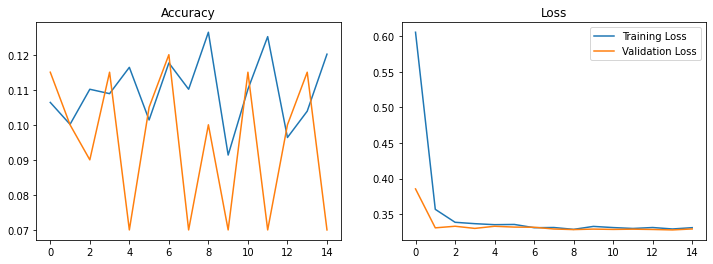

In [13]:
# Plotting the history, which has Accuracy and Loss

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss')
plt.legend()

plt.show()